In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [15]:
train = pd.read_csv("W22_P2_train.csv")
test = pd.read_csv('W22_P2_test.csv')

In [16]:
train.head()

,id,genre,description
0,1722,documentary,Quality Control consists of a series of 16mm ...
1,7915,documentary,Tom Beacham explores Ghana with Director of P...
2,5434,documentary,The story of the Castle and Family of Norbert...
3,4640,comedy,A gang of unemployed itinerant musicians play...
4,9590,comedy,When Artie needs money for his daughters cons...


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10000 non-null  int64 
 1   genre        10000 non-null  object
 2   description  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6000 non-null   int64 
 1   description  6000 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.9+ KB


In [19]:
print(train.isnull().any())
print(test.isnull().any())

id             False
genre          False
description    False
dtype: bool
id             False
description    False
dtype: bool


In [20]:
train['genre'].value_counts()

 documentary     2500
 comedy          2500
 drama           2500
 short           2500
Name: genre, dtype: int64

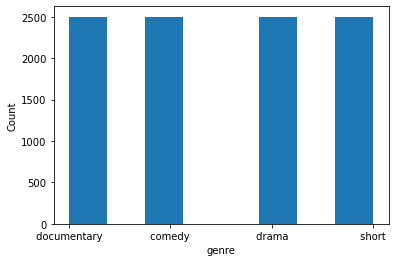

In [21]:
plt.hist(train['genre'].values, bins=8)
plt.xlabel('genre')
plt.ylabel('Count')
plt.show()

In [22]:
train['ID'] = train['genre'].factorize()[0]
ID_train = train[['genre','ID']].drop_duplicates().sort_values('ID')
category_to_id = dict(ID_train.values)
id_to_category = dict(ID_train[['ID','genre']].values)
train.head()

,id,genre,description,ID
0,1722,documentary,Quality Control consists of a series of 16mm ...,0
1,7915,documentary,Tom Beacham explores Ghana with Director of P...,0
2,5434,documentary,The story of the Castle and Family of Norbert...,0
3,4640,comedy,A gang of unemployed itinerant musicians play...,1
4,9590,comedy,When Artie needs money for his daughters cons...,1


In [76]:
# Build the tfidf matrix
text_content = train['description']
vector = TfidfVectorizer(max_df=0.4,    # drop words that occur in more than X percent of documents
                         min_df=1,      # only use words that appear at least X times
                         stop_words='english',  # remove stop words
                         lowercase=True,  # Convert everything to lower case
                         use_idf=True,   # Use idf
                         norm='l2',     # Normalization
                         )
vector.fit(text_content)
# tfidf = vector.fit_transform(text_content)
tfidf = vector.transform(text_content)
labels =train.ID
tfidf.shape


  (0, 48796)	0.02554158811114722
  (0, 48607)	0.06573176895598105
  (0, 48515)	0.07506739534424504
  (0, 48501)	0.08938338857505726
  (0, 48493)	0.044149154771415317
  (0, 48319)	0.08575059929359909
  (0, 47942)	0.08829830954283063
  (0, 44376)	0.04881626575179891
  (0, 44053)	0.13558656226790708
  (0, 43531)	0.12308301434698066
  (0, 42771)	0.06271535196171571
  (0, 42699)	0.08394360133339375
  (0, 42454)	0.15613919136550514
  (0, 41412)	0.07806959568275257
  (0, 41285)	0.08519816190678794
  (0, 40347)	0.07887539136049532
  (0, 40283)	0.10206821834294384
  (0, 40028)	0.059181674115752696
  (0, 40009)	0.10333082888716802
  (0, 39992)	0.10001273625770007
  (0, 39778)	0.0747435977930746
  (0, 39466)	0.06408107351788532
  (0, 39417)	0.058035218067867406
  (0, 38746)	0.1281713665449044
  (0, 37810)	0.0486742761137343
  :	:
  (9999, 34505)	0.0843306702845551
  (9999, 33538)	0.07289913515060459
  (9999, 30098)	0.09335818100554297
  (9999, 30050)	0.08146895625799652
  (9999, 29976)	0.10157550

In [ ]:
print(tfidf)

In [85]:
N=3
for genre, ID in sorted(category_to_id.items()):
    features_chi2 = chi2(tfidf, labels == ID)
    indices = np.argsort(features_chi2[0])
    features_names = np.array(vector.get_feature_names())[indices]
    unigrams = [v for v in features_names if len(v.split(' '))==1]
    print("# '{}':".format(genre))
    print(" . Most correlated unigrams:\n. {}".format('\n.'. join(unigrams[-N:])))

# ' comedy ':
 . Most correlated unigrams:
. film
.hilarious
.comedy
# ' documentary ':
 . Most correlated unigrams:
. history
.interviews
.documentary
# ' drama ':
 . Most correlated unigrams:
. daughter
.father
.son
# ' short ':
 . Most correlated unigrams:
. poem
.experimental
.short


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, labels, test_size= 0.2, random_state= 0)

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [69]:
num_folds = 10
seed = 7
scoring = 'accuracy'

fiting Naive Bayes to the Training set

In [86]:
param_grid = {}
param_grid['alpha'] = [0.001, 0.2, 0.3, 0.5,0.7, 1, 1.5,2]
model = MultinomialNB()
kfold = KFold(n_splits=num_folds,random_state=seed, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X=X_train, y=Y_train)
print('Best : %s using %s' % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best : 0.6322500000000001 using {'alpha': 0.5}


C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [87]:
nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(X_train, Y_train)

C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB(alpha=0.5)

In [88]:
valid =nb_classifier.predict(X_test)

In [89]:
score_ = accuracy_score(Y_test, valid)
print("Accuracy score is: {}%".format(round(score_*100,2)))

Accuracy score is: 64.65%


In [90]:
nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(tfidf, labels)

MultinomialNB(alpha=0.5)

In [91]:
vec_test=vector.transform(test['description'])

In [92]:
test['label']=nb_classifier.predict(vec_test)

In [93]:
test.head()

,id,description,label
0,14626,Frankie Reno was a child star on a TV show. B...,1
1,11338,Coming from an upper-middle class background ...,2
2,15465,"Whether it's blocking up mouse holes, running...",1
3,13496,"Fighter pilot, inventor, spy - the life of Ro...",0
4,13912,"To entertain some thieves, a blind guitar pla...",0


In [94]:
label_to_genre={0:' documentary ',1:' comedy ',2:' drama ',3:' short '}

In [95]:
finalPred =test['label'].apply(lambda x:label_to_genre[x])

In [96]:
test_id = test["id"]

In [97]:
submission = pd.concat([test_id, pd.DataFrame(finalPred)], axis=1)
submission.columns = ['id','genre']

submission.to_csv("submission_NB.csv", index=False)

SVC

In [98]:
param_grid = {}
param_grid={"C":[0.2,0.5,1,3]}
model = LinearSVC()
kfold = KFold(n_splits=num_folds,random_state=seed, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X=X_train, y=Y_train)
print('best : %s using %s' % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


best : 0.64025 using {'C': 0.2}


C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [99]:
model = LinearSVC(C=0.2)
model.fit(X_train, Y_train)

valid =model.predict(X_test)



C:\Users\Ivy\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [100]:
score_ = accuracy_score(Y_test, valid)
print("Accuracy score is: {}%".format(round(score_*100,2)))

Accuracy score is: 66.8%


In [101]:
model.fit(tfidf, labels)

LinearSVC(C=0.2)

In [102]:
test['label']=model.predict(vec_test)

In [103]:
test.head()

,id,description,label
0,14626,Frankie Reno was a child star on a TV show. B...,1
1,11338,Coming from an upper-middle class background ...,2
2,15465,"Whether it's blocking up mouse holes, running...",1
3,13496,"Fighter pilot, inventor, spy - the life of Ro...",0
4,13912,"To entertain some thieves, a blind guitar pla...",0


In [104]:
label_to_genre={0:' documentary ',1:' comedy ',2:' drama ',3:' short '}

In [109]:
print(label_to_genre)

{0: ' documentary ', 1: ' comedy ', 2: ' drama ', 3: ' short '}


In [105]:
Pred =test['label'].apply(lambda x:label_to_genre[x])

In [106]:
test_id = test["id"]

In [107]:
submission = pd.concat([test_id, pd.DataFrame(Pred)], axis=1)
submission.columns = ['id','genre']

submission.to_csv("submission_SVC.csv", index=False)